In [2]:
from PIL import ImageChops
from PIL import Image
import numpy as np
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.stats import pearsonr
import pickle

In [3]:
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.datasets as datasets

In [4]:
# my files
from load_model import load_model
os.environ["CUDA_VISIBLE_DEVICES"] = '3'

In [5]:
def read_sorted_filename(data_path):
    # read img filenames
    all_filenames = []
    for filename in os.listdir(data_path):
        if filename[-4:]=='.png':
            all_filenames.append(filename)
    
    # sort img filenames -> fix bug of sorting by value
    if all_filenames[0][:13]=='canvasvisible':
        all_filenames = sorted(all_filenames, key=lambda x: int(x[:-4].split("_")[-1][5:]))
    elif all_filenames[0][:8]=='trialnum':
        all_filenames = sorted(all_filenames, key=lambda x: int(x[8:-4]))
    
    return all_filenames

# compute diff - model based

In [21]:
def get_model_level_diff(data_path_0, data_path_1, data_path_ori, model_name):
    # read data
    all_filenames_0 = read_sorted_filename(data_path_0)
    all_filenames_1 = read_sorted_filename(data_path_1)
    all_filenames_ori = read_sorted_filename(data_path_ori)

    print("data_path_1 length: ", len(all_filenames_0), "data_path_ori length: ", len(all_filenames_ori))
    sample_per_img = int(len(all_filenames_0) / len(all_filenames_ori))
    
    # get model
    model = load_model(model_name)
    model.eval()
    
    # add hook
    activation = {}
    def get_activation(name):
        def hook(model, input, output):
            activation[name] = output.detach()
        return hook
    if 'simplecnn' in model_name:
        model.fc2.register_forward_hook(get_activation('feats'))
    elif model_name == 'alexnet':
        model.classifier[5].register_forward_hook(get_activation('feats'))
    elif model_name == 'vgg16':
        model.classifier[4].register_forward_hook(get_activation('feats'))
    elif 'onlyDM' in model_name:
        model.depth_predictor.encoder[4].register_forward_hook(get_activation('feats'))
        # model.depth_predictor.decoder[30].register_forward_hook(get_activation('feats'))
        # model.depth_predictor.encoder[6].register_forward_hook(get_activation('feats'))
    else: # resnet50
        model.avgpool.register_forward_hook(get_activation('feats'))
    
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                         std=[0.229, 0.224, 0.225])
    _trans = transforms.Compose([
            transforms.Resize(224),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            normalize,
        ])
    
    
    # compute diff
    all_diff = np.zeros((sample_per_img, len(all_filenames_ori), 2))
    for img_index in tqdm(range(len(all_filenames_ori))):
        # read ori img
        img_path_ori = os.path.join(data_path_ori, all_filenames_ori[img_index])
        img_ori = Image.open(img_path_ori).convert("RGB")
        for sample_index in range(sample_per_img):
            # read samples img
            cur_index = img_index * sample_per_img + sample_index
            img_path_0 = os.path.join(data_path_0, all_filenames_0[cur_index])
            img_path_1 = os.path.join(data_path_1, all_filenames_1[cur_index])
            img_0 = Image.open(img_path_0).convert("RGB")
            img_1 = Image.open(img_path_1).convert("RGB")
            
            # extract feats
            FEATS = []
            # loop through batches
            for idx, img in enumerate([img_ori, img_0, img_1]):
                # read & transform img
                img_trans = _trans(img)
                # move to device
                inputs = img_trans.unsqueeze(0).cuda()
                # forward pass [with feature extraction]
                preds = model(inputs)
                FEATS.append(activation['feats'].cpu().squeeze().unsqueeze(0).numpy())
            FEATS = np.concatenate(FEATS, axis=0)
                        
            # compute diff
            img_diff_0 = np.abs(FEATS[0] - FEATS[1]).mean()
            img_diff_1 = np.abs(FEATS[0] - FEATS[2]).mean()
            all_diff[sample_index][img_index][0] = img_diff_0
            all_diff[sample_index][img_index][1] = img_diff_1

    return all_diff

In [65]:
# resnet50
# alexnet
# vggface
# rn50_preIN_notexture_sizeVar_best
# rn50_preIN_texture_sizeVar_best
# rn50_FromScratch_notexture_sizeVar_best
# rn50_FromScratch_texture_sizeVar_best
# rn50_preIN_notexture_sizeVar_2losses
# resnet50-trained-pretrained-vbsl
# resnet50-trained-scratch-vbsl
# rn50_vbsl-dist-ft_epoch15

## get pixel-level diff
model_name = 'resnet50-trained-pretrained-vbsl'

# path0 -> same as label
data_path_0 = "../data/face_data/gt3drenderer/20230417_vbsl151upright_samples100_noise0.05vs_elias_IfElias/"
data_path_1 = "../data/face_data/gt3drenderer/20230417_vbsl151upright_samples100_noise0.05vs_elias_IfNeptune/"
data_path_ori = "../data/face_data/gt3drenderer/20230421_vbsl151upright_elias/"

# diff: [num_sample, num_img, 2]
diff_elias = get_model_level_diff(data_path_0, data_path_1, data_path_ori, model_name)

data_path_0 = "../data/face_data/gt3drenderer/20230417_vbsl151upright_samples100_noise0.05vs_neptune_IfNeptune/"
data_path_1 = "../data/face_data/gt3drenderer/20230417_vbsl151upright_samples100_noise0.05vs_neptune_IfElias/"
data_path_ori = "../data/face_data/gt3drenderer/20230421_vbsl151upright_neptune/"

diff_neptune = get_model_level_diff(data_path_0, data_path_1, data_path_ori, model_name)

data_path_1 length:  5000 data_path_ori length:  50
loading resnet50-trained-pretrained-vbsl
loaded 256bs_pretrained_model_best.pth.tar


100%|███████████████████████████████████████████| 50/50 [02:50<00:00,  3.41s/it]


data_path_1 length:  5000 data_path_ori length:  50
loading resnet50-trained-pretrained-vbsl
loaded 256bs_pretrained_model_best.pth.tar


100%|███████████████████████████████████████████| 50/50 [02:51<00:00,  3.44s/it]


# compute diff - pixel

In [12]:
def get_pixel_level_diff(data_path_0, data_path_1, data_path_ori):
    # read data
    all_filenames_0 = read_sorted_filename(data_path_0)
    all_filenames_1 = read_sorted_filename(data_path_1)
    all_filenames_ori = read_sorted_filename(data_path_ori)

    print(len(all_filenames_0), len(all_filenames_ori))
    sample_per_img = int(len(all_filenames_0) / len(all_filenames_ori))
    
    # compute diff
    all_diff = np.zeros((sample_per_img, len(all_filenames_ori), 2))
    for img_index in tqdm(range(len(all_filenames_ori))):

        # read ori img
        img_path_ori = os.path.join(data_path_ori, all_filenames_ori[img_index])
        img_ori = Image.open(img_path_ori)
        for sample_index in range(sample_per_img):
            # read samples img
            cur_index = img_index * sample_per_img + sample_index
            img_path_0 = os.path.join(data_path_0, all_filenames_0[cur_index])
            img_path_1 = os.path.join(data_path_1, all_filenames_1[cur_index])
            img_0 = Image.open(img_path_0)
            img_1 = Image.open(img_path_1)

            # compute diff
            img_diff_0 = ImageChops.difference(img_0, img_ori)
            img_diff_1 = ImageChops.difference(img_1, img_ori)
            all_diff[sample_index][img_index][0] = np.array(img_diff_0).mean()
            all_diff[sample_index][img_index][1] = np.array(img_diff_1).mean()

    return all_diff

In [13]:
## get pixel-level diff
# path0 -> same as label
data_path_0 = "../data/face_data/gt3drenderer/20230417_vbsl151upright_samples100_noise0.05vs_elias_IfElias/"
data_path_1 = "../data/face_data/gt3drenderer/20230417_vbsl151upright_samples100_noise0.05vs_elias_IfNeptune/"
data_path_ori = "../data/face_data/gt3drenderer/20230421_vbsl151upright_elias/"

# diff: [num_sample, num_img, 2]
diff_elias = get_pixel_level_diff(data_path_0, data_path_1, data_path_ori)

data_path_0 = "../data/face_data/gt3drenderer/20230417_vbsl151upright_samples100_noise0.05vs_neptune_IfNeptune/"
data_path_1 = "../data/face_data/gt3drenderer/20230417_vbsl151upright_samples100_noise0.05vs_neptune_IfElias/"
data_path_ori = "../data/face_data/gt3drenderer/20230421_vbsl151upright_neptune/"

diff_neptune = get_pixel_level_diff(data_path_0, data_path_1, data_path_ori)

5000 50


100%|███████████████████████████████████████████| 50/50 [00:43<00:00,  1.15it/s]


5000 50


 94%|████████████████████████████████████████▍  | 47/50 [00:41<00:02,  1.15it/s]


KeyboardInterrupt: 

# compute i1

In [66]:
# diff_elias [num_rep, num_sample, 2], [:,:,0]->true, [:,:,1]->false
mean_diff_elias = (diff_elias[:,:,1] - diff_elias[:,:,0])
mean_diff_neptune = (diff_neptune[:,:,1] - diff_neptune[:,:,0])
mean_diff = np.concatenate([mean_diff_elias, mean_diff_neptune], axis=1)

In [67]:
# normalize by std
norm_factor = np.sqrt((diff_elias[:,:,1].var(0) + diff_elias[:,:,0].var(0))/2)
norm_factor = np.expand_dims(norm_factor, axis=0)
mean_diff_elias_norm = (diff_elias[:,:,1] - diff_elias[:,:,0]) / norm_factor

norm_factor = np.sqrt((diff_neptune[:,:,1].var(0) + diff_neptune[:,:,0].var(0))/2)
norm_factor = np.expand_dims(norm_factor, axis=0)
mean_diff_neptune_norm = (diff_neptune[:,:,1] - diff_neptune[:,:,0]) / norm_factor

mean_diff_norm = np.concatenate([mean_diff_elias_norm, mean_diff_neptune_norm], axis=1)

1.0


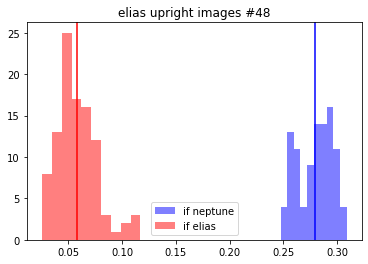

In [71]:
# show diff dist for an img
for image_index in range(50):
    acc = (diff_elias[:,image_index,1].reshape(-1) - diff_elias[:,image_index,0].reshape(-1)) > 0
    if acc.mean() < 1.0:
        print(image_index, acc)
        
image_index = 48

plt.hist(diff_elias[:,image_index,1].reshape(-1), alpha=0.5, label='if neptune', color='blue')
plt.axvline(diff_elias[:,image_index,1].mean(), color='blue')

plt.hist(diff_elias[:,image_index,0].reshape(-1), alpha=0.5, label='if elias', color='red')
plt.axvline(diff_elias[:,image_index,0].mean(), color='red')

acc = (diff_elias[:,image_index,1].reshape(-1) - diff_elias[:,image_index,0].reshape(-1)) > 0
print(acc.mean())

plt.title(f"elias upright images #{image_index}")
plt.legend()
plt.show()

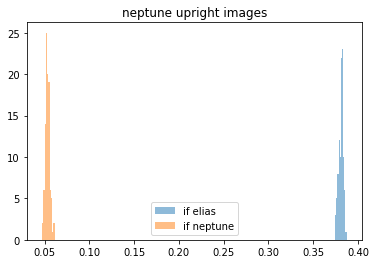

In [69]:
plt.hist(diff_neptune[:,:,1].mean(1), alpha=0.5, label='if elias')
plt.hist(diff_neptune[:,:,0].mean(1), alpha=0.5, label='if neptune')
plt.title("neptune upright images")
plt.legend()
plt.show()

In [43]:
## compute i1 and i1_5rep
# direct
place_holder = mean_diff
model_i1s = place_holder.mean(0)
model_i1s_5rep = []
num_rep = place_holder.shape[0]
for rep_index in range(5):
    np.random.shuffle(place_holder)
    tmp = np.concatenate([place_holder[:int(num_rep/2)].mean(0), 
                          place_holder[int(num_rep/2):].mean(0)])
    model_i1s_5rep.append(np.expand_dims(tmp, axis=0))
model_i1s_5rep = np.concatenate(model_i1s_5rep, axis=0)
# normalized
place_holder = mean_diff_norm
model_i1s_norm = place_holder.mean(0)
model_i1s_5rep_norm = []
num_rep = place_holder.shape[0]
for rep_index in range(5):
    np.random.shuffle(place_holder)
    tmp = np.concatenate([place_holder[:int(num_rep/2)].mean(0), 
                          place_holder[int(num_rep/2):].mean(0)])
    model_i1s_5rep_norm.append(np.expand_dims(tmp, axis=0))
model_i1s_5rep_norm = np.concatenate(model_i1s_5rep_norm, axis=0)

In [44]:
# read model i1s
import pickle
with open('useful_stats_penn.pkl', 'rb') as f:
    useful_stats = pickle.load(f)

In [45]:
# record
_name = f'ideal3drenderer_{model_name}'
# _name = f'ideal3drenderer'
print(_name)
useful_stats['../../data/face_data/vbsl_151/'][_name] = {}
useful_stats['../../data/face_data/vbsl_151/'][_name]['i1_upright'] = model_i1s
useful_stats['../../data/face_data/vbsl_151/'][_name]['i1_5rep_upright'] = model_i1s_5rep
useful_stats['../../data/face_data/vbsl_151/'][_name]['i1_upright_norm'] = model_i1s_norm
useful_stats['../../data/face_data/vbsl_151/'][_name]['i1_5rep_upright_norm'] = model_i1s_5rep_norm

# save
import pickle
with open('useful_stats_penn.pkl', 'wb') as f:
    pickle.dump(useful_stats, f)

ideal3drenderer_rn50_vbsl-dist-ft_epoch15


# compare i1

In [46]:
# read
import pickle
with open('useful_stats_penn.pkl', 'rb') as f:
    useful_stats = pickle.load(f)

In [47]:
def subset_upright_302(array): # (302,) to (100,)
    return np.concatenate([array[0:25], array[50:75], array[151:151+25], array[151+50:151+75]])
def subset_upright_5rep_604(array): # (5, 604) to (5, 200)
    return np.concatenate([array[:, 0:25], array[:, 50:75], 
                            array[:, 151:151+25], array[:, 151+50:151+75], 
                            array[:, 302:302+25], array[:, 302+50:302+75], 
                            array[:, 302+151:302+151+25], array[:, 302+151+50:302+151+75], ], axis=1)

In [48]:
# read bio i1
import pickle
_path = "../data/face_data/bio_data/human-avg-sub_20211011_Var6vbsl_set0_im151_elias_dur200ms_lab_updated.json_20211011_Var6vbsl_set0_im151_neptune_dur200ms_lab_updated.json"
with open(_path, 'rb') as f:
    human_i1 = pickle.load(f).squeeze().reshape(-1)
_path = "../data/face_data/bio_data/human-avg-sub_20211011_Var6vbsl_set0_im151_elias_dur200ms_lab_updated.json_20211011_Var6vbsl_set0_im151_neptune_dur200ms_lab_updated.json_n_rep=5"
with open(_path, 'rb') as f:
    human_i1_5rep = pickle.load(f).squeeze()

# only upright
human_i1 = subset_upright_302(human_i1)
human_i1_5rep = subset_upright_5rep_604(human_i1_5rep)
human_i1.shape, human_i1_5rep.shape

((100,), (5, 200))

In [49]:
# read marmoset i1
_path = "../data/face_data/bio_data/avg-monkey-i1_splithalf"
with open(_path, 'rb') as f:
    marmoset_i1_5rep = pickle.load(f).squeeze()

_path = "../data/face_data/bio_data/avg-monkey-i1"
with open(_path, 'rb') as f:
    marmoset_i1 = pickle.load(f).squeeze().reshape(-1)
    
# only upright
marmoset_i1 = subset_upright_302(marmoset_i1)
marmoset_i1_5rep = subset_upright_5rep_604(marmoset_i1_5rep)
marmoset_i1.shape, marmoset_i1_5rep.shape

((100,), (5, 200))

In [50]:
# get model i1
_name = 'resnet50-trained-pretrained-vbsl'
rn50_apple_ft_i1_5rep = useful_stats['../../data/face_data/vbsl_151/'][_name]['i1_5rep']
rn50_apple_ft_i1_5rep_upright = subset_upright_5rep_604(rn50_apple_ft_i1_5rep)

_name = 'rn50_vbsl-dist-ft_epoch15'
rn50_apple_ft_dist_i1_5rep = useful_stats['../../data/face_data/vbsl_151/'][_name]['i1_5rep']
rn50_apple_ft_dist_i1_5rep_upright = subset_upright_5rep_604(rn50_apple_ft_dist_i1_5rep)

In [63]:
# get model i1
tmp_model_i1_5rep = useful_stats['../../data/face_data/vbsl_151/']["alexnet"]['i1_5rep']
tmp_model_i1_5rep_upright = subset_upright_5rep_604(tmp_model_i1_5rep)

In [64]:
# compare i1 - ideal 3d renderer
use_norm = True
# model_names_list = ['ideal3drenderer', 
#                     'ideal3drenderer_resnet50',
#                     'ideal3drenderer_alexnet', 
#                     'ideal3drenderer_resnet50-trained-pretrained-vbsl',
#                     'ideal3drenderer_rn50_vbsl-dist-ft_epoch15']
model_names_list = ['ideal3drenderer']

bio_i1s = human_i1_5rep
# bio_i1s = marmoset_i1_5rep
# bio_i1s = rn50_apple_ft_i1_5rep_upright
# bio_i1s = rn50_apple_ft_dist_i1_5rep_upright

i1_list = []
i1_std_list = []
for model_name in model_names_list:
    print(model_name)
    if use_norm:
        model_i1s_5rep = useful_stats['../../data/face_data/vbsl_151/'][model_name]['i1_5rep_upright_norm']
    else:
        model_i1s_5rep = useful_stats['../../data/face_data/vbsl_151/'][model_name]['i1_5rep_upright']
    
    model_i1s_5rep = tmp_model_i1_5rep_upright
    
    i1_corr = []
    model_internal = []
    half_length = int(model_i1s_5rep.shape[1]/2)
    for rep_index in range(5):
        corr_1, _ = pearsonr(model_i1s_5rep[rep_index][:half_length], bio_i1s[rep_index][half_length:])
        corr_2, _ = pearsonr(model_i1s_5rep[rep_index][half_length:], bio_i1s[rep_index][:half_length])
        corr_3, _ = pearsonr(model_i1s_5rep[rep_index][:half_length], model_i1s_5rep[rep_index][half_length:])
        corr_4, _ = pearsonr(bio_i1s[rep_index][half_length:], bio_i1s[rep_index][:half_length])
        # print(corr_1, corr_2, corr_3, corr_4)
        i1_corr.append(0.5*(corr_1+corr_2)/np.sqrt(corr_3*corr_4))
        model_internal.append(corr_3)
    # print(model_internal)
    print("i1: %.4f±%.4f" % (np.mean(np.array(i1_corr)), np.std(np.array(i1_corr))))
    i1_list.append(np.mean(np.array(i1_corr)) * 100)
    i1_std_list.append(np.std(np.array(i1_corr)) * 100)

ideal3drenderer
i1: 0.0304±0.0405


In [42]:
# human_i1_list = i1_list
# human_i1_std_list = i1_std_list

# apple_ft_i1_list = i1_list
# apple_ft_i1_std_list = i1_std_list

# apple_ft_dist_i1_list = i1_list
# apple_ft_dist_i1_std_list = i1_std_list

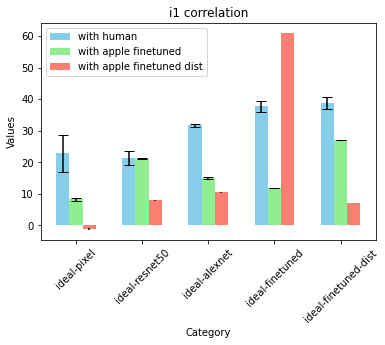

In [50]:
categories = ['ideal-pixel', 
            'ideal-resnet50',
                'ideal-alexnet',
                'ideal-finetuned',
             'ideal-finetuned-dist',]

x = np.arange(len(categories))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, human_i1_list, yerr=human_i1_std_list,
                width=width, label='with human', capsize=5, color='skyblue')
rects2 = ax.bar(x + 0, apple_ft_i1_list, yerr=apple_ft_i1_std_list,
                width=width, label='with apple finetuned', capsize=5, color='lightgreen')
rects3 = ax.bar(x + width, apple_ft_dist_i1_list, yerr=apple_ft_dist_i1_std_list,
                width=width, label='with apple finetuned dist', color='salmon')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Category')
ax.set_ylabel('Values')
ax.set_title('i1 correlation')
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.legend()
plt.xticks(rotation=45)
plt.show()

In [6]:
human_i1_list

NameError: name 'human_i1_list' is not defined

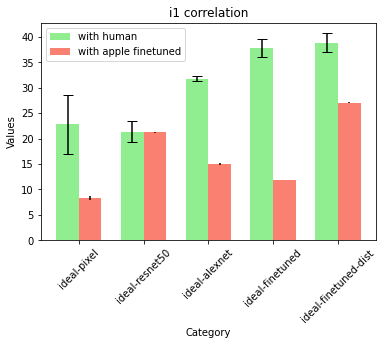

In [52]:
categories = ['ideal-pixel', 
            'ideal-resnet50',
                'ideal-alexnet',
                'ideal-finetuned',
             'ideal-finetuned-dist',]

x = np.arange(len(categories))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects2 = ax.bar(x - width/2, human_i1_list, yerr=human_i1_std_list,
                width=width, label='with human', capsize=5, color='lightgreen')
rects3 = ax.bar(x + width/2, apple_ft_i1_list, yerr=apple_ft_i1_std_list,
                width=width, label='with apple finetuned', color='salmon')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Category')
ax.set_ylabel('Values')
ax.set_title('i1 correlation')
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.legend()
plt.xticks(rotation=45)
plt.show()

In [73]:
# record
useful_stats['../../data/face_data/vbsl_151/'][_name]['i1_corr'] = (np.mean(np.array(i1_corr)), np.std(np.array(i1_corr)))

# save
import pickle
with open('useful_stats_penn.pkl', 'wb') as f:
    pickle.dump(useful_stats, f)

# compare i1 - old

In [31]:
def subset_upright_302(array): # (302,) to (100,)
    return np.concatenate([array[0:25], array[50:75], array[151:151+25], array[151+50:151+75]])
def subset_upright_5rep_604(array): # (5, 604) to (5, 200)
    return np.concatenate([array[:, 0:25], array[:, 50:75], 
                            array[:, 151:151+25], array[:, 151+50:151+75], 
                            array[:, 302:302+25], array[:, 302+50:302+75], 
                            array[:, 302+151:302+151+25], array[:, 302+151+50:302+151+75], ], axis=1)

In [32]:
# read bio i1
import pickle
_path = "../data/face_data/bio_data/human-avg-sub_20211011_Var6vbsl_set0_im151_elias_dur200ms_lab_updated.json_20211011_Var6vbsl_set0_im151_neptune_dur200ms_lab_updated.json"
with open(_path, 'rb') as f:
    human_i1 = pickle.load(f).squeeze().reshape(-1)
_path = "../data/face_data/bio_data/human-avg-sub_20211011_Var6vbsl_set0_im151_elias_dur200ms_lab_updated.json_20211011_Var6vbsl_set0_im151_neptune_dur200ms_lab_updated.json_n_rep=5"
with open(_path, 'rb') as f:
    human_i1_5rep = pickle.load(f).squeeze()

# only upright
human_i1 = subset_upright_302(human_i1)
human_i1_5rep = subset_upright_5rep_604(human_i1_5rep)
human_i1.shape, human_i1_5rep.shape

((100,), (5, 200))

In [33]:
data_root = '../../data/face_data/vbsl_151/'
bio_i1s = human_i1_5rep
tmp_results = {data_root: {}}

In [34]:
model_name_list = ['resnet50', 'alexnet', 'vggface',  # baseline
                    'resnet50-SIN', 'resnet50-SIN-IN', 'resnet50-SIN-IN-ft', # stylized imagenet
                    'rn50_preIN_notexture_sizeVar_best', 'rn50_preIN_texture_sizeVar_best', # basel finetuned
                   'rn50_FromScratch_notexture_sizeVar_best', 'rn50_FromScratch_texture_sizeVar_best', # basel FromScratch
                    'rn50_preIN_notexture_sizeVar_2losses', # DepthMap prediction
                   'resnet50-trained-pretrained-vbsl', 'resnet50-trained-scratch-vbsl', 'rn50_vbsl-dist-ft_epoch15'] # vbsl
for model_name in model_name_list:
    tmp_results[data_root][model_name]={}
    model_i1_5rep = useful_stats[data_root][model_name]['i1_5rep']
    model_i1_5rep = subset_upright_5rep_604(model_i1_5rep)
    
    i1_corr = []
    bio_internal = []
    half_length = int(model_i1_5rep.shape[1]/2)
    for rep_index in range(5):
        corr_1, _ = pearsonr(model_i1_5rep[rep_index][:half_length], bio_i1s[rep_index][half_length:])
        corr_2, _ = pearsonr(model_i1_5rep[rep_index][half_length:], bio_i1s[rep_index][:half_length])
        corr_3, _ = pearsonr(model_i1_5rep[rep_index][:half_length], model_i1_5rep[rep_index][half_length:])
        corr_4, _ = pearsonr(bio_i1s[rep_index][half_length:], bio_i1s[rep_index][:half_length])
        # print(corr_1, corr_2, corr_3, corr_4)
        i1_corr.append(0.5*(corr_1+corr_2)/np.sqrt(corr_3*corr_4))
        bio_internal.append(corr_4)
    print(model_name)
    print("i1: %.6f±%.6f" % (np.mean(np.array(i1_corr)), np.std(np.array(i1_corr))))
    tmp_results[data_root][model_name]['i1_corr'] = np.mean(np.array(i1_corr)), np.std(np.array(i1_corr))

resnet50
i1: -0.020075±0.008767
alexnet
i1: 0.030390±0.040468
vggface
i1: 0.112216±0.022352
resnet50-SIN
i1: 0.029067±0.020086
resnet50-SIN-IN
i1: 0.047273±0.013480
resnet50-SIN-IN-ft
i1: 0.039194±0.009100
rn50_preIN_notexture_sizeVar_best
i1: 0.017821±0.015214
rn50_preIN_texture_sizeVar_best
i1: 0.286854±0.021103
rn50_FromScratch_notexture_sizeVar_best
i1: -0.044985±0.024318
rn50_FromScratch_texture_sizeVar_best
i1: 0.047134±0.022238
rn50_preIN_notexture_sizeVar_2losses
i1: 0.127793±0.023547
resnet50-trained-pretrained-vbsl
i1: 0.166754±0.036972
resnet50-trained-scratch-vbsl
i1: 0.327154±0.020008
rn50_vbsl-dist-ft_epoch15
i1: 0.576794±0.034308


In [37]:
# compare i1 - ideal 3d renderer
i1_corr = []
model_internal = []
half_length = int(model_i1s_5rep.shape[1]/2)
for rep_index in range(5):
    corr_1, _ = pearsonr(model_i1s_5rep[rep_index][:half_length], bio_i1s[rep_index][half_length:])
    corr_2, _ = pearsonr(model_i1s_5rep[rep_index][half_length:], bio_i1s[rep_index][:half_length])
    corr_3, _ = pearsonr(model_i1s_5rep[rep_index][:half_length], model_i1s_5rep[rep_index][half_length:])
    corr_4, _ = pearsonr(bio_i1s[rep_index][half_length:], bio_i1s[rep_index][:half_length])
    # print(corr_1, corr_2, corr_3, corr_4)
    i1_corr.append(0.5*(corr_1+corr_2)/np.sqrt(corr_3*corr_4))
    model_internal.append(corr_3)
print(model_internal)
print("i1: %.6f±%.6f" % (np.mean(np.array(i1_corr)), np.std(np.array(i1_corr))))

tmp_results[data_root][_name] = {}
tmp_results[data_root][_name]['i1_corr'] = (np.mean(np.array(i1_corr)), np.std(np.array(i1_corr)))

[0.9306784558624435, 0.9505667813992731, 0.9528429574308106, 0.9482015339580597, 0.9425646877360986]
i1: 0.213644±0.020822
gt3drenderer_rn50_vbsl-dist-ft_epoch15


(0.2798559707188337, 0.004803054456397258)

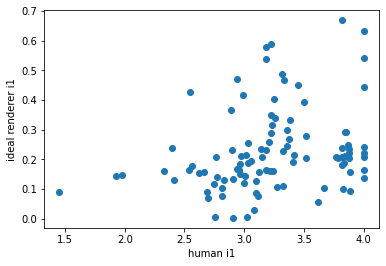

In [15]:
# i1 corr
plt.scatter(human_i1, model_i1s)
plt.xlabel("human i1")
plt.ylabel("ideal renderer i1")
pearsonr(human_i1, model_i1s)

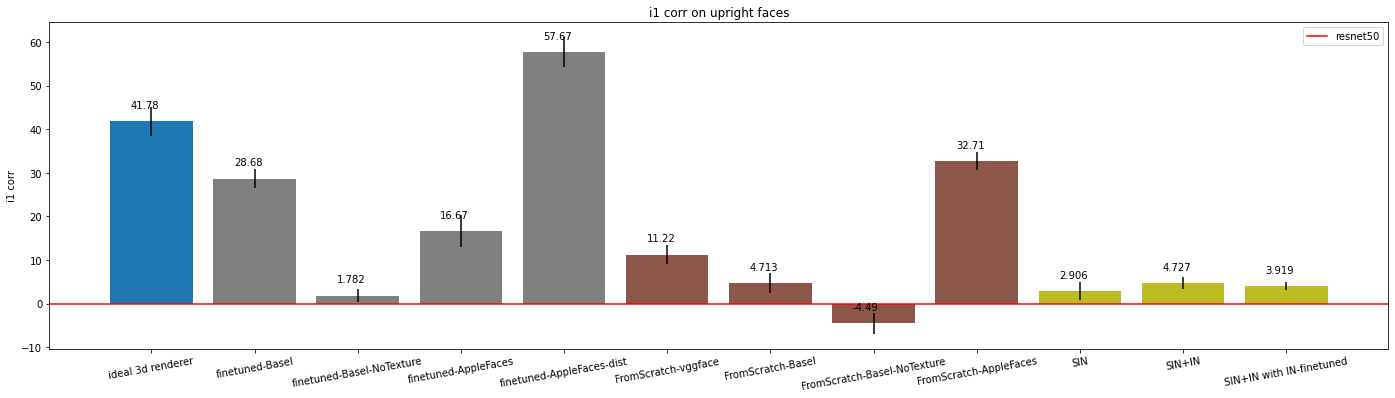

In [16]:
# plot acc - all
model_group = ['gt3drenderer', 'rn50_preIN_texture_sizeVar_best', 'rn50_preIN_notexture_sizeVar_best',
                    'resnet50-trained-pretrained-vbsl', 'rn50_vbsl-dist-ft_epoch15'] + \
                   ['vggface', 'rn50_FromScratch_texture_sizeVar_best', 'rn50_FromScratch_notexture_sizeVar_best',
                   'resnet50-trained-scratch-vbsl'] + \
                   ['resnet50-SIN', 'resnet50-SIN-IN', 'resnet50-SIN-IN-ft']
model_ReadableNames = ['ideal 3d renderer', 'finetuned-Basel', 'finetuned-Basel-NoTexture', 'finetuned-AppleFaces', 'finetuned-AppleFaces-dist'] + \
                          ['FromScratch-vggface', 'FromScratch-Basel', 'FromScratch-Basel-NoTexture', 'FromScratch-AppleFaces'] + \
                          ['SIN', 'SIN+IN', 'SIN+IN with IN-finetuned']
color_list = ['tab:blue'] + ['tab:grey'] * 4 + ['tab:brown'] * 4 + ['tab:olive'] * 3

baseline = tmp_results[data_root]["resnet50"]['i1_corr'][0]
# read numbers
acc_mean_list = []
acc_std_list = []
for model_name in model_group:
    acc = tmp_results[data_root][model_name]['i1_corr']
    acc_mean_list.append(acc[0]*100)
    acc_std_list.append(acc[1]*100)

# plot
plt.figure(figsize=(2*len(model_group), 6))
plt.bar(model_ReadableNames, acc_mean_list, 
        yerr=acc_std_list, color = color_list)

for i, v in enumerate(acc_mean_list):
    plt.text(i-0.2, v+3, str(v)[:5])

# plt.ylim([45, 100])
plt.xticks(rotation=10)
plt.title("i1 corr on upright faces")
plt.ylabel("i1 corr")
data_name = data_root.split("/")[-2]

plt.axhline(y=baseline, color='r', linestyle='-', label="resnet50")
plt.legend()
plt.show()

## mv original upright faces

In [10]:
## move original upright faces
source_path = "../data/face_data/20211011_Var6vbsl_set0_im151_elias/"
target_path = "../data/face_data/gt3drenderer/vbsl151upright_elias/"
all_filenames = read_sorted_filename(source_path)
upright_filenames = all_filenames[:25] + all_filenames[50:75]

for img_index, filename in enumerate(upright_filenames):
    img = Image.open(os.path.join(source_path, filename))
    # crop
    cropped_img = crop_alpha(img)
    # save
    cropped_img.save(os.path.join(target_path, filename))

In [7]:
def crop_alpha(img):
    """
    Crop out the parts of the image where alpha value is zero.
    """
    alpha = img.split()[-1]  # Get the alpha channel
    bbox = alpha.getbbox()   # Get the bounding box of the non-zero alpha region
    cropped = img.crop(bbox) # Crop the image to the bounding box
    return cropped